# 0.0. Imports

In [138]:
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'

# 0.1. Helper Function

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

# 0.2. Load dataset

In [6]:
df_raw = pd.read_csv( '../data/raw/train.csv' )

In [7]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [8]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [9]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2. Data Dimensions

In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1. Numerical Attributes

In [14]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [15]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0. Data Filtering

In [16]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis

In [17]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Age

<AxesSubplot:xlabel='response', ylabel='age'>

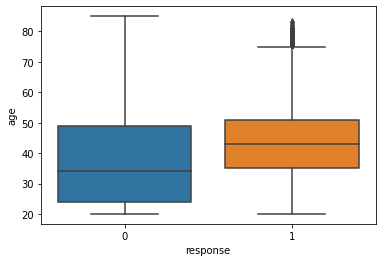

In [18]:
sns.boxplot( x='response', y='age', data=df4 )

<AxesSubplot:xlabel='age', ylabel='Count'>

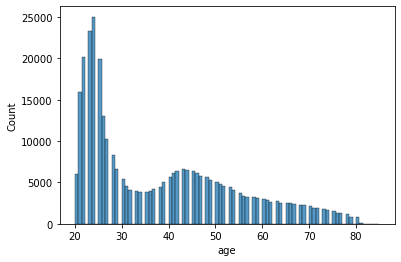

In [19]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

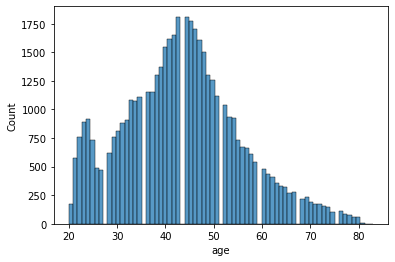

In [20]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

### 4.1.2. Anual Income

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

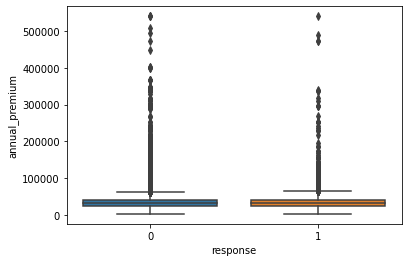

In [21]:
sns.boxplot( x='response', y='annual_premium', data=df4 )

In [22]:
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]

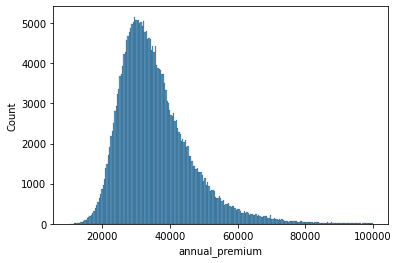

In [23]:
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

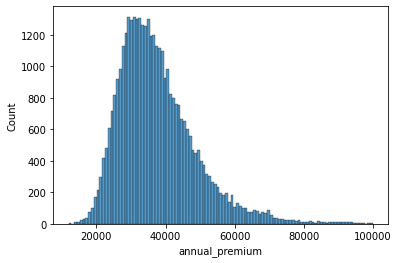

In [24]:
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

### 4.1.3. Driving License

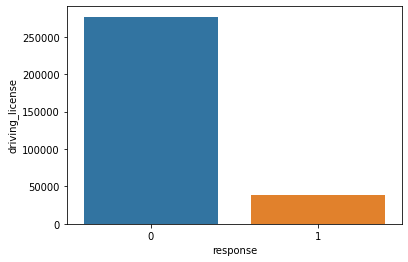

In [25]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.4. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

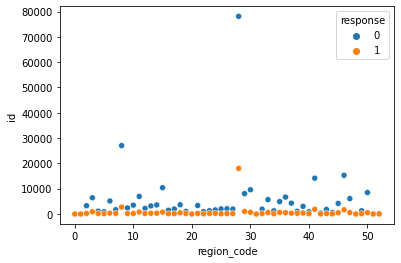

In [26]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

### 4.1.5. Previously Insured

<AxesSubplot:xlabel='previously_insured', ylabel='id'>

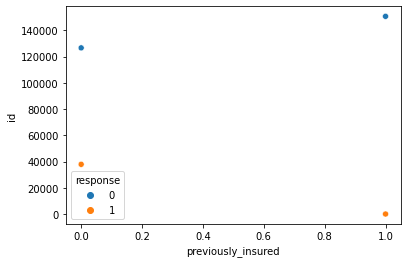

In [27]:
aux0 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='previously_insured', y='id', hue='response', data=aux0 )

In [28]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


### 4.1.6. Vehicle Age

In [29]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,137861
1,below_1_year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


### 4.1.7. Vehicle Damage

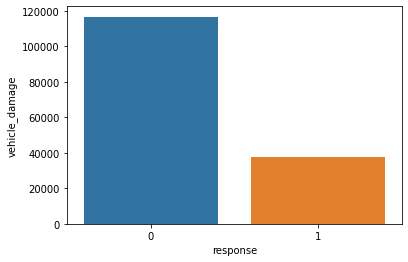

In [30]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.8. Policy Sales Channel - Stacked Percentage Bar

In [31]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.( x='response', y='policy_sales_channel', data=aux );

SyntaxError: invalid syntax (<ipython-input-31-a40c3dfd0116>, line 2)

In [32]:
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux.head()

,policy_sales_channel,response,total_responses
0,1.0,0,10
1,2.0,0,1
2,3.0,136,434
3,4.0,90,442
4,6.0,0,2


### 4.1.9. Vintage

<AxesSubplot:xlabel='vintage', ylabel='Count'>

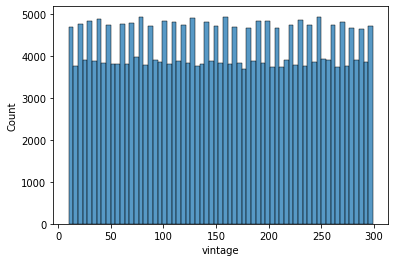

In [33]:
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

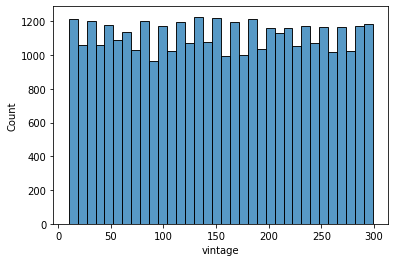

In [34]:
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

In [35]:
df = pd.pivot_table( index='vintage', columns='response', values='id', data=df5).reset_index()
df.columns = ['vintage', 'no_response', 'yes_response']

NameError: name 'df5' is not defined

In [ ]:
df.plot( x='vintage', kind='bar', stacked=True)

# 5.0. Data Preparation

In [36]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [37]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [38]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3. Transformation

### 5.3.1. Encoding

In [39]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

## 5.4. Validation Preparation

In [40]:
# gender
x_val.loc[:, 'gender'] =  x_val.loc[:, 'gender'].map( target_encode_gender )

# age
x_val.loc[:, 'age'] = mms_age.transform( x_val[['age']].values )

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform( x_val[['annual_premium']].values )

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform( x_val[['vintage']].values )

# fillna
x_val = x_val.fillna( 0 )

# 6.0. Feature Selection

## 6.1. Boruta Algorithm

In [41]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


In [42]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Feature Importance

In [43]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                annual_premium    0.274656
0                       vintage    0.249636
0                           age    0.156044
0                   region_code    0.101166
0                vehicle_damage    0.070005
0            previously_insured    0.059914
0          policy_sales_channel    0.057562
0      vehicle_age_below_1_year    0.015756
0  vehicle_age_between_1_2_year    0.006945
0                        gender    0.004741
0      vehicle_age_over_2_years    0.003068
0               driving_license    0.000506


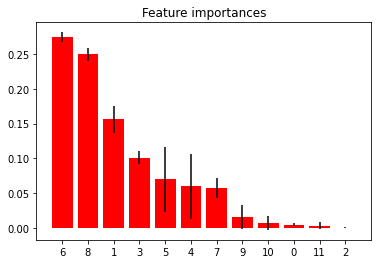

In [44]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [45]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [46]:
x_train = df5[ cols_selected ]
x_val = x_val[ cols_selected ]

## 7.1. KNN Classifier

In [160]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

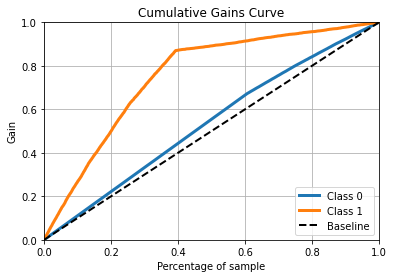

In [161]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

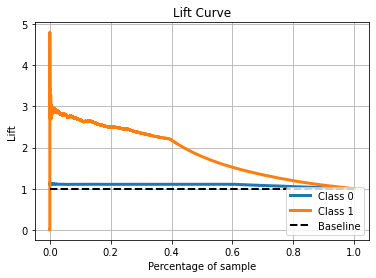

In [162]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2. Logistic Regression

In [135]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

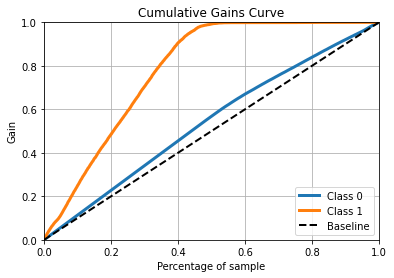

In [136]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

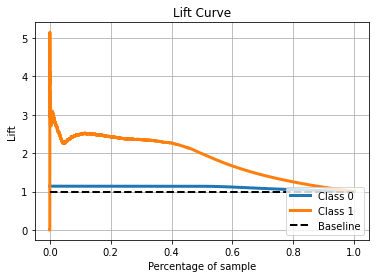

In [137]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3. Extra Trees Classifier



In [172]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

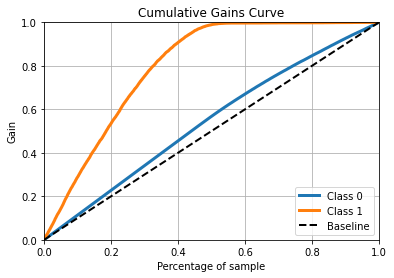

In [173]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

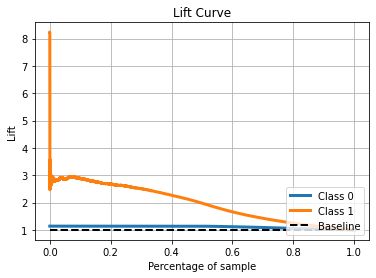

In [174]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_et );

## 7.4. Random Forest

In [175]:
# model definition
rf = en.RandomForestClassifier( n_estimators=2000, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = et.predict_proba( x_val )

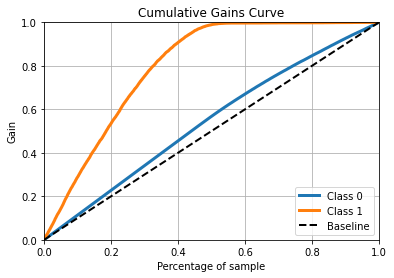

In [176]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

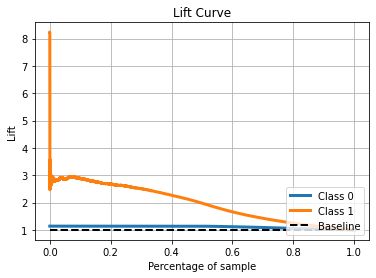

In [177]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

# Accumulative Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

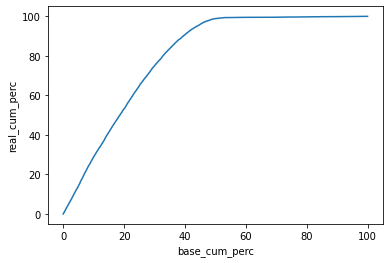

In [120]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )